# 27.2.3 Relax Inc. Take-Home Challenge
Relax Inc. makes productivity and project management software that's popular with both individuals and teams. Founded by several former Facebook employees, it's considered a great company to work for.

A  user  table  ( "takehome_users" )  with  data  on  12,000  users  who  signed  up  for  the
product  in  the  last  two  years.   This  table  includes:

● name:  the  user's  name

● object_id:   the  user's  id

● email:  email  address

● creation_source:   how  their  account  was  created.  This  takes  on  one of  5  values:

    ○ PERSONAL_PROJECTS:  invited  to  join  another  user's personal  workspace
    
    ○ GUEST_INVITE:  invited  to  an  organization  as  a  guest (limited  permissions)
    
    ○ ORG_INVITE:  invited  to  an  organization  (as  a  full  member)
    
    ○ SIGNUP:  signed  up  via  the  website
    
    ○ SIGNUP_GOOGLE_AUTH:  signed  up  using  Google Authentication  (using  a  Google  email  account  for  their  login id)
● creation_time:  when  they  created  their  account

● last_session_creation_time:   unix  timestamp  of  last  login

● opted_in_to_mailing_list:  whether  they  have  opted  into  receiving marketing  emails

● enabled_for_marketing_drip:  whether  they  are  on  the  regular marketing  email  drip

● org_id:   the  organization  (group  of  users)  they  belong  to

● invited_by_user_id:   which  user  invited  them  to  join  (if  applicable).

2]  A  usage  summary  table  ( "takehome_user_engagement" )  that  has  a  row  for  each  day that  a  user  logged  into  the  product.

Defining  an  "adopted  user"   as  a  user  who   has  logged  into  the  product  on  three  separate days  in  at  least  one  seven-day  period ,  identify  which  factors  predict  future  user adoption.

Please  send  us  a  brief  writeup  of  your  findings  (the  more  concise,  the  better -- no  more
than  one  page),  along  with  any  summary  tables,  graphs,  code,  or  queries  that  can  help
us  understand  your  approach.  Please  note  any  factors  you  considered  or  investigation
you  did,  even  if  they  did  not  pan  out.  Feel  free  to  identify  any  further  research  or  data
you  think  would  be  valuable.

In [1]:
%reset -f
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# import tensorflow
import tensorflow as tf
#import keras 
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn
import os
os.chdir('C:/Sereda/Lectures/Springboard/27.Effective_Interviewing_for_Data_Scientists/relax_challenge')

In [2]:
m = pd.read_csv('takehome_users.csv', encoding='latin1', parse_dates=['last_session_creation_time']).\
    drop(['name','email'], axis=1)
# encoding is necessary for reading special characters, such as 'æ'
m.head(3)

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,GUEST_INVITE,1398138810,1,0,11,10803.0
1,2,2013-11-15 03:45:04,ORG_INVITE,1396237504,0,0,1,316.0
2,3,2013-03-19 23:14:52,ORG_INVITE,1363734892,0,0,94,1525.0


In [3]:
# usage data
u = pd.read_csv('takehome_user_engagement.csv', index_col = None, parse_dates=['time_stamp'])
#u['time_stamp'] = pd.to_datetime(u['time_stamp']) # str -> Timestamp
u.head(3)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1


### Generate labels
Defining  an  "adopted  user"   as  a  user  who   has  logged  into  the  product  on  three  separate days  in  at  least  one  seven-day  period ,  identify  which  factors  predict  future  user adoption.

In [4]:
u.head(3)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1


In [5]:
u['visited'].unique()

array([1], dtype=int64)

Since 'visited'=1, we can use this column for aggregation (to calculate the number of visits in each 7-day period).

In [6]:
# Resample using 7-day period, Multiple Aggregation on sampled data
users = u['user_id'].unique()
adopt = []
for i in users:
    u_filter = u[u['user_id'] == i].set_index('time_stamp').resample("1D").count() # 1 or 0 for every day
    u_filter = u_filter.rolling(window=7).sum() # sum over 1 week
    u_filter = u_filter.dropna()
    adopt.append(any(u_filter['visited'].values >= 3))
users_adopt = pd.DataFrame(list(zip(users, adopt))) # format: (1391, False)
# Merge two tables: users and usage
users_adopt.columns = ['object_id', 'adopt']
df = m.merge(users_adopt, on='object_id', how='left')
df.drop(['last_session_creation_time'], axis=1, inplace=True)
df.head(3)

,object_id,creation_time,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopt
0,1,2014-04-22 03:53:30,GUEST_INVITE,1,0,11,10803.0,False
1,2,2013-11-15 03:45:04,ORG_INVITE,0,0,1,316.0,True
2,3,2013-03-19 23:14:52,ORG_INVITE,0,0,94,1525.0,False


Not all users have usage information:

In [7]:
print("No. of users:",len(m.object_id.unique()))
print("No. of users with usage info:",len(u.user_id.unique()))

No. of users: 12000
No. of users with usage info: 8823


As a result of this, some users will have null label to be predicted. Such records will be the prediction set.

In [8]:
df_train_test = df.loc[df['adopt'].notnull()]
df_predict = df.loc[df['adopt'].isnull()]
print("Train & test:",df_train_test.shape)
print("Predict:",df_predict.shape)

Train & test: (8823, 8)
Predict: (3177, 8)


In [9]:
# Convert labels False/true to 0/1
#df.loc[:, 'adopt'] = df['adopt'].map({False:0, True:1}) #, np.nan:0
df['adopt'] = df['adopt'].map({False:0, True:1})
df.dropna(subset=['adopt'], inplace=True)
df['adopt'] = df['adopt'].astype(int) # make labels integer
df['creation_time'] = pd.to_datetime(df['creation_time']) # to datetime
df.head()

,object_id,creation_time,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopt
0,1,2014-04-22 03:53:30,GUEST_INVITE,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,ORG_INVITE,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,ORG_INVITE,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,GUEST_INVITE,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,GUEST_INVITE,0,0,193,5240.0,0


### Feature engineering
Let's add seasonal information.

In [10]:
df['creation_month'] = df['creation_time'].dt.month
df['creation_weekday'] = df['creation_time'].dt.weekday

In [11]:
# mapping 'invited_by_user_id' => 'invited_by_user'
invited = lambda rec: 0 if np.isnan(rec) else 1
df['invited_by_user'] = df['invited_by_user_id'].apply(invited)
df.drop(['creation_time','invited_by_user_id'], axis=1, inplace=True)
df.set_index('object_id', inplace=True)

In [12]:
df.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopt,creation_month,creation_weekday,invited_by_user
object_id,,,,,,,,
1,GUEST_INVITE,1,0,11,0,4,1,1
2,ORG_INVITE,0,0,1,1,11,4,1
3,ORG_INVITE,0,0,94,0,3,1,1
4,GUEST_INVITE,0,0,1,0,5,1,1
5,GUEST_INVITE,0,0,193,0,1,3,1


In [13]:
df['creation_source'].value_counts()

ORG_INVITE            3188
SIGNUP                1898
GUEST_INVITE          1588
SIGNUP_GOOGLE_AUTH    1385
PERSONAL_PROJECTS      764
Name: creation_source, dtype: int64

In [14]:
df['opted_in_to_mailing_list'].value_counts()

0    6597
1    2226
Name: opted_in_to_mailing_list, dtype: int64

In [15]:
df['enabled_for_marketing_drip'].value_counts()

0    7482
1    1341
Name: enabled_for_marketing_drip, dtype: int64

In [16]:
df['org_id'].value_counts()

0      228
1      172
2      150
3      125
4      122
      ... 
396      6
400      6
397      5
386      4
416      2
Name: org_id, Length: 417, dtype: int64

### Encoding

In [17]:
# One-hot encoding based on data type
df = pd.get_dummies(df, drop_first=False, columns=['creation_source','creation_month','org_id'])
# 'org_id' is label-encoded
print(df.shape)
df.head(3)

(8823, 439)


,opted_in_to_mailing_list,enabled_for_marketing_drip,adopt,creation_weekday,invited_by_user,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,...,org_id_407,org_id_408,org_id_409,org_id_410,org_id_411,org_id_412,org_id_413,org_id_414,org_id_415,org_id_416
object_id,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,4,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Scaling

In [18]:
#scale_cols = ['org_id']
# now we scling all the data 
#scale = MinMaxScaler()
#df[scale_cols] = scale.fit_transform(df[scale_cols]) # -1 to 1

### Independent and dependent variables, splitting

In [19]:
# independent and dependent variables
X = df.drop('adopt',axis=1)
y = df['adopt']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)
print(X_train.shape)
print(X_test.shape)

(6176, 438)
(2647, 438)


### Binary Prediction using Artificial Neural Network
https://www.analyticsvidhya.com/blog/2021/10/customer-churn-prediction-using-artificial-neural-network/

Now we have to define our model, - set the parameters and layers of the deep neural network which will be used for training the data.

In [297]:
# define sequential NN model
model = keras.Sequential([
    keras.layers.Dense(438, input_shape=(None,438), activation='relu'), # input layer
    keras.layers.Dense(219,activation = 'relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(50,activation = 'relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(10,activation = 'relu'),
    keras.layers.Dense(5,activation = 'gelu'),
    keras.layers.Dense(2,activation = 'relu'),
    keras.layers.Dense(1, activation='sigmoid')]) # output layer, use sigmoid for binary output

In [298]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy','AUC']) # compile neural net.
history_model = model.fit(X_train, y_train, epochs=30) # fit our model to training data

Epoch 1/30
193/193 [==============================] - 1s 3ms/step - loss: 0.4902 - accuracy: 0.8188 - auc: 0.5205
Epoch 2/30
193/193 [==============================] - 1s 3ms/step - loss: 0.4481 - accuracy: 0.8216 - auc: 0.6506
Epoch 3/30
193/193 [==============================] - 1s 3ms/step - loss: 0.4284 - accuracy: 0.8216 - auc: 0.7142
Epoch 4/30
193/193 [==============================] - 1s 3ms/step - loss: 0.4033 - accuracy: 0.8216 - auc: 0.7691
Epoch 5/30
193/193 [==============================] - 1s 3ms/step - loss: 0.3535 - accuracy: 0.8347 - auc: 0.8427
Epoch 6/30
193/193 [==============================] - 1s 3ms/step - loss: 0.2798 - accuracy: 0.8753 - auc: 0.9090
Epoch 7/30
193/193 [==============================] - 1s 3ms/step - loss: 0.2037 - accuracy: 0.9152 - auc: 0.9528
Epoch 8/30
193/193 [==============================] - 1s 3ms/step - loss: 0.1469 - accuracy: 0.9451 - auc: 0.9747
Epoch 9/30
193/193 [==============================] - 1s 3ms/step - loss: 0.1088 - accur

Here we define sequential model, in which the input, hidden and output layers are connected in a sequential manner. We define one input layer which contains all 20 columns as an input, second and third layer is hidden layers which contain 15, 10 hidden neurons and here we apply RelU activation function. Our last layer is the output layer, as our output is in the form of 1 and 0 so, we will use the sigmoid activation function.

Now we compile our sequential model and fit the training data into our model.

#### Evaluate our model

In [299]:
model.evaluate(X_test,y_test)

83/83 [==============================] - 0s 2ms/step - loss: 2.7276 - accuracy: 0.7412 - auc: 0.5132


[2.727637767791748, 0.7412164807319641, 0.5131543874740601]

In [300]:
print(history_model.params)
print(history_model.history)

{'verbose': 1, 'epochs': 30, 'steps': 193}
{'loss': [0.4901769459247589, 0.44806838035583496, 0.4283888041973114, 0.4032585322856903, 0.3535172939300537, 0.27978572249412537, 0.2036772221326828, 0.1468811184167862, 0.1088123545050621, 0.08726123720407486, 0.06823623925447464, 0.05705944448709488, 0.05294201523065567, 0.05035858973860741, 0.04248552396893501, 0.04244757816195488, 0.03451607748866081, 0.03742272034287453, 0.032425180077552795, 0.0427202470600605, 0.038256965577602386, 0.03492016717791557, 0.03541092947125435, 0.02788064070045948, 0.024662181735038757, 0.026130281388759613, 0.02647489309310913, 0.030312402173876762, 0.02517806366086006, 0.028546815738081932], 'accuracy': [0.818814754486084, 0.8215673565864563, 0.8215673565864563, 0.8215673565864563, 0.8346826434135437, 0.8753238320350647, 0.9151554107666016, 0.9451100826263428, 0.9600064754486084, 0.9659973978996277, 0.9724740982055664, 0.9739313721656799, 0.9768458604812622, 0.9766839146614075, 0.9800841808319092, 0.9805

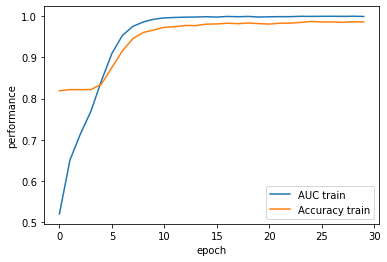

In [301]:
# Plot training performance
plt.plot(history_model.history['auc'])
#plt.plot(history_model.history['val_auc'])
plt.plot(history_model.history['accuracy'])
#plt.plot(history_model.history['val_accuracy'])
plt.legend(['AUC train', 'Accuracy train']);
plt.xlabel('epoch');
plt.ylabel('performance');

### Predict

In [302]:
# predict the labels
y_pred = model.predict(X_test)
# unscaling the y_pred values 
y_pred_lis = []
for i in y_pred:
    if i > 0.5:
        y_pred_lis.append(1)
    else:
        y_pred_lis.append(0)
#print(y_pred_lis)

#make dataframe for comparing the orignal and predicted values
data = {'original_label':y_test, 'predicted_label':y_pred_lis}
df_check = pd.DataFrame(data)
df_check.head(10)

,original_label,predicted_label
object_id,,
1759,1,0
7994,0,0
7547,0,0
1865,1,1
8683,0,0
3604,0,0
10574,1,0
1168,0,0
10526,1,1


              precision    recall  f1-score   support

           0       0.82      0.87      0.85      2152
           1       0.24      0.17      0.20       495

    accuracy                           0.74      2647
   macro avg       0.53      0.52      0.52      2647
weighted avg       0.71      0.74      0.72      2647



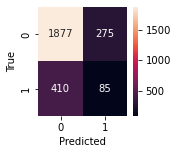

In [304]:
# Performance metrics
print(classification_report(y_test,y_pred_lis))
# ploting the confusion matrix plot
conf_mat = tf.math.confusion_matrix(labels=y_test,predictions=y_pred_lis)
plt.figure(figsize = (2,2))
seaborn.heatmap(conf_mat, annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True');

In [ ]:
1793,118

This is a strongly imbalanced set, presenting a difficulty for sequential NN model. In addition, the model is impossible to interpret. It is better to try tree-based ensemble models. Accuracy has increased after adding seasonal variables 'creation_month' and 'creation_weekday'.